# Prerequisites & Set-up #

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import torch as th
from torchvision import datasets, transforms

import itertools
import time

import sklearn
from sklearn.model_selection import train_test_split
import numpy as np

from google.colab.patches import cv2_imshow
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading The Dataset ##

The length:  4
350


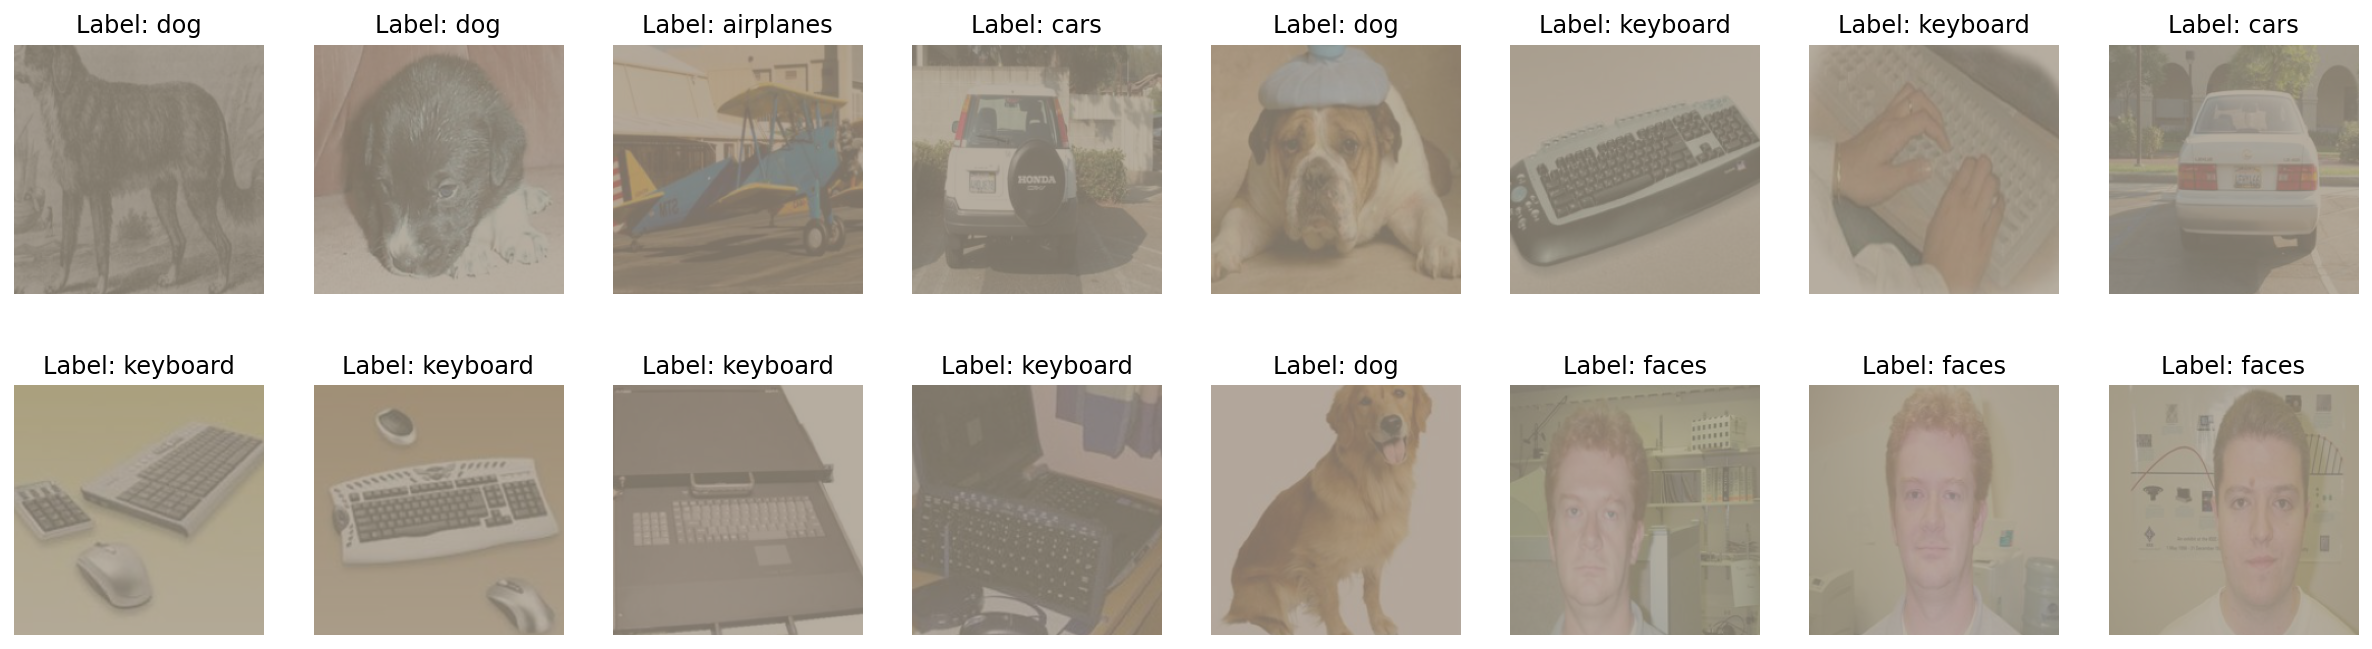

In [ ]:
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

dataset = datasets.ImageFolder('gdrive/MyDrive/COMP338_Assignment2_Dataset/Training', transform=transform)
dataset_testing = datasets.ImageFolder('gdrive/MyDrive/COMP338_Assignment2_Dataset/Test', transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_testing, batch_size=16, shuffle=True)
print("The length: ", len(test_loader))

# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))

# DEBUG: Show dataset
def showimages(imgs,actual_lbls,pred_lbls=None):
   
  fig = plt.figure(figsize=(21,12))
 
  for i,img in enumerate(imgs):
     
    fig.add_subplot(4,8, i+1)
    y=actual_lbls[i]
     
    if pred_lbls!=None:
      y_pre=pred_lbls[i]
      title="prediction: {0}\nlabel:{1}".format(dataset.classes[y],dataset.classes[y_pre])
    else: 
      title="Label: {0}".format(dataset.classes[y])
 
    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)
   
plt.show()
 
inputs, classes = next(iter(dataloader))
 
showimages(inputs,classes)

print(len(dataset))

# Global Variables #

In [ ]:
global_learning_rate = 0.00001
epochs = 20
test_batch_size = 4

# STEP 1: Feature Extraction Using A CNN #

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn_layers = Sequential(

            # First Hidden Layer
            Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            BatchNorm2d(64),
            ReLU(inplace=True),

            # Second Hidden Layer (Pooling Layer 1)
            MaxPool2d(kernel_size=3, stride=2, padding=0),

            # Third Hidden Layer
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),

            # Fourth Hidden Layer (Pooling Layer 2)
            MaxPool2d(kernel_size=3, stride=2, padding=0),
        )

        self.linear_layers = Sequential(
            # Fully Connected Layer
            nn.Linear(46656, 5)
        )

        self.softmax = Sequential(
            nn.Softmax()
        )


     # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = self.softmax(x)
        return x

In [ ]:
zclass CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn_layers = Sequential(

            # First Hidden Layer
            Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            BatchNorm2d(64),
            ReLU(inplace=True),

            # Second Hidden Layer (Pooling Layer 1)
            MaxPool2d(kernel_size=3, stride=2, padding=0),

            # Third Hidden Layer
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),

            # Fourth Hidden Layer (Pooling Layer 2)
            MaxPool2d(kernel_size=3, stride=2, padding=0),
        )

        self.linear_layers = Sequential(
            # Fully Connected Layer
            nn.Linear(46656, 5)
        )

        self.softmax = Sequential(
            nn.Softmax()
        )


     # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = self.softmax(x)
        return x

# STEP 2: Loss Function And Optimiser #

In [ ]:
def createLossAndOptimizer(net, learning_rate=global_learning_rate):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

TODO: Try different learning rates 

# STEP 3: Train The Network #

In [ ]:
# The number has to be 350 to make sure that it matches with out dataset
n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000 # Might need to be altered in the future

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

print(len(val_sampler))
print(len(dataset))

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

# Data Loader #

def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, #sampler=train_sampler,
                                              num_workers=2)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(dataset, batch_size=128, #sampler=val_sampler,
                                          num_workers=2)

5000
350


In [ ]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = dataloader #get_train_loader(batch_size) #dataloader
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        #print("1")
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            #print("2")
            # zero the parameter gradients
            optimizer.zero_grad()
            #print("3")
            # forward + backward + optimize
            #print(inputs)
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #print("4")
            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))
        print("New Run!")
        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          print("Ehe")
          for inputs, labels in val_loader:
              print("Hello There")
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [ ]:
# Run the network
model = CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=global_learning_rate) #'0.07
# defining the loss function
criterion = CrossEntropyLoss()

print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=46656, out_features=5, bias=True)
  )
  (softmax): Sequential(
    (0): Softmax(dim=None)
  )
)


In [ ]:

# TRAINING
# FINAL MODEL AS VARIABLE
train_history, val_history = train(model, batch_size=16, n_epochs=epochs, learning_rate=global_learning_rate)

===== HYPERPARAMETERS =====
batch_size= 16
n_epochs= 20
learning_rate= 1e-05


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1, 13% 	 train_loss: 2.33 took: 2.63s
Epoch 1, 27% 	 train_loss: 2.34 took: 2.50s
Epoch 1, 40% 	 train_loss: 2.31 took: 2.52s
Epoch 1, 54% 	 train_loss: 2.28 took: 2.52s
Epoch 1, 68% 	 train_loss: 2.23 took: 2.52s
Epoch 1, 81% 	 train_loss: 2.23 took: 2.51s
Epoch 1, 95% 	 train_loss: 2.15 took: 2.50s
New Run!
Ehe
Hello There
Hello There
Hello There
Validation loss = 1.41
Epoch 2, 13% 	 train_loss: 2.02 took: 2.52s
Epoch 2, 27% 	 train_loss: 2.12 took: 2.51s
Epoch 2, 40% 	 train_loss: 2.04 took: 2.52s
Epoch 2, 54% 	 train_loss: 2.14 took: 2.48s
Epoch 2, 68% 	 train_loss: 1.96 took: 2.86s
Epoch 2, 81% 	 train_loss: 1.95 took: 2.50s
Epoch 2, 95% 	 train_loss: 1.92 took: 2.49s
New Run!
Ehe
Hello There
Hello There
Hello There
Validation loss = 1.31
Epoch 3, 13% 	 train_loss: 1.98 took: 2.92s
Epoch 3, 27% 	 train_loss: 1.87 took: 2.52s
Epoch 3, 40% 	 train_loss: 1.85 took: 2.53s
Epoch 3, 54% 	 train_loss: 2.00 took: 2.51s
Epoch 3, 68% 	 train_loss: 1.81 took: 2.53s
Epoch 3, 81% 	 train

## Plot Losses ##

1.4145242770512898
1.314424991607666
1.257295290629069
1.2312638759613037
1.1928048133850098
1.1744505167007446
1.1527572870254517
1.1388040781021118
1.126240034898122
1.1027302145957947
1.091863214969635
1.080572505791982
1.0706789294878643
1.0639879902203877
1.0501394271850586
1.0484296878178914
1.0368659893671672
1.0420316259066265
1.0211912592252095
1.0149698456128438


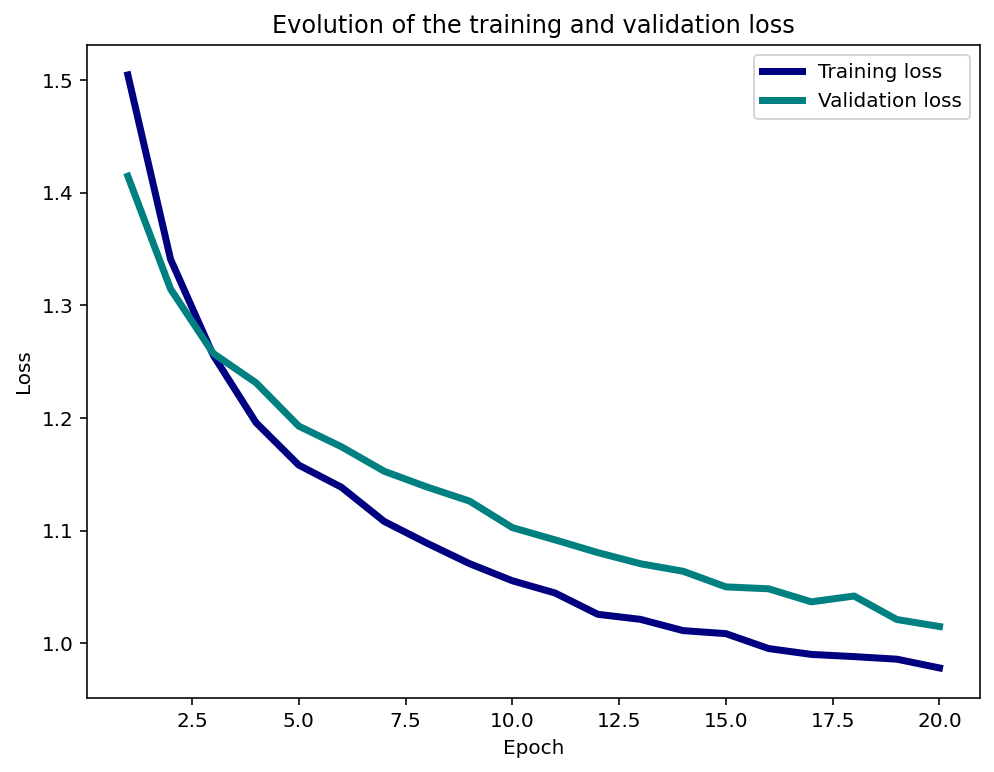

In [ ]:
# Plot losses over epochs
for x in val_history:
  print(x)

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    colours = [[0, 0, 128], [0, 128, 128]]
    colours = [(r / 255, g / 255, b / 255) for (r, g, b) in colours]

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colours[0], label="Training loss", linewidth=3.5)
    plt.plot(x, val_history, color=colours[1], label="Validation loss", linewidth=3.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

# Output
plot_losses(train_history, val_history)

## Plot Change Of Accuracies over Epochs ##

In [ ]:
# Stores the accuracy values per epoch (accumulated)
accuracies = []

# Calculate total accuracy and accuracies per epoch
def dataset_accuracy_over_epoch(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracies.append(100 * float(correct) / total)
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

# Output
dataset_accuracy_over_epoch(model, dataloader, "Training Accuracies BY Epoch")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on the 350 Training Accuracies BY Epoch images: 96.86 %


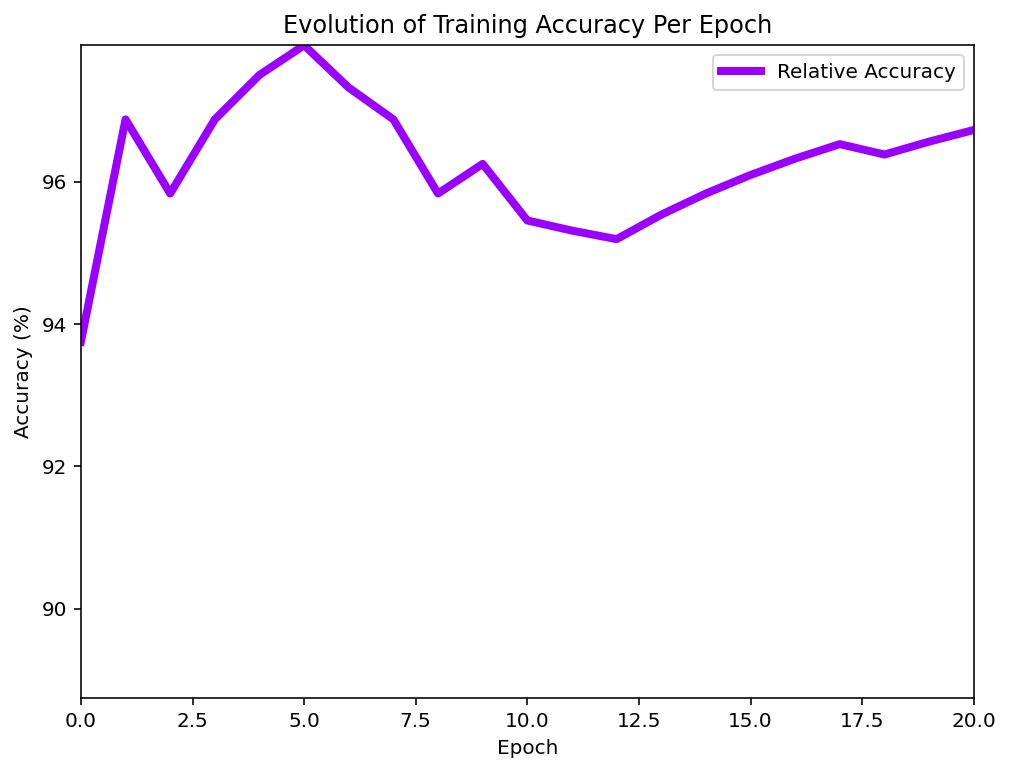

In [ ]:
# The the accuracy values for each epoch
def plot_accuracy():
    x = np.arange(0, len(accuracies))

    colours = [[153, 0, 255]]
    colours = [(r / 255, g / 255, b / 255) for (r, g, b) in colours]

    plt.figure(figsize=(8, 6))
    plt.plot(x, accuracies, color=colours[0], label="Relative Accuracy", linewidth=4)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='upper right')
    plt.title("Evolution of Training Accuracy Per Epoch")

    # Setting relative limits to improve appearance of the graph
    plt.xlim([0, epochs])
    plt.ylim([min(accuracies) - 5, max(accuracies)])

    plt.show()

plot_accuracy()